# **An Exploratory Data Analysis of the NBA in the 2023-24 Season**
## By Koops0


### Introduction
The 2023-24 NBA season can be summarized by the Timberwolves popping off, Wemby, the Josh Giddey controversy, the first ever In Season Tournament, 克萊湯普森在對陣國王隊的淘汰賽中以 0-10 獲勝, the Celtics having more NBA rings than the Lakers and 5 free boneless wings from Wingstop. But, there are still some burning questions that one might have about this season. In preperation for the 2024-25 season, I'll be doing an exploratory data analysis at the 2023-24 regular season and how a player or team performed. The dataset that I am using this time will be my own, but I'll be following Jamie's process in making the specific dataset that I used last year, which is the "NBA Player Salaries (2022-23 Season)" dataset on Kaggle [1].

While crafting my dataset, I did have a few questions written down that I wanted to address by doing the EDA. These are the following questions:

1. From last year, what is the best scenario to potentially achieve the maximum amount of success if one gets drafted via stats, efficiency and position? Is the ideal scenario still a late 1st pick as a Center or has the game changed?
2. Rookie of the Year was a hot topic this season. Based on this, is Victor Wembanyama truly this generation's GOAT or is it someone else, like Chet Holmgren, Scottie Barnes or Anthony Edwards?
3. To win games, teams should be optimized by starting the best players. I know that injuries happen and they get swapped out by replacements, but I want to know if simply starting that replacement for all 82 games would give that team a better result. Do teams that don't make the playoffs actually make it with the replacement?

### Methods
#### Data Collection

As explained in the introduction, I am using my own dataset. The script for scraping data via BeautifulSoup is in the same folder.

In [44]:
#PYTHON LIBRARY IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
import xgboost as xgb

In [2]:
#Loading Data
nba_data = pd.read_csv('nba_salaries.csv')
nba_data

,Player,Salary,Position,Age,Team,GP,Minutes Played,PER,TS%,3PAr,...,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
0,Stephen Curry,51915615,PG,35,GSW,74,2421,20.6,0.616,0.606,...,11.7,31.3,5.2,2.0,7.2,0.142,6.3,-1.1,5.2,4.4
1,Kevin Durant,47649433,PF,35,PHO,75,2791,21.2,0.626,0.283,...,13.1,29.0,5.1,3.2,8.3,0.142,4.0,0.1,4.0,4.3
2,Nikola Jokic,47607350,C,28,DEN,79,2737,31.0,0.650,0.164,...,12.9,29.3,12.0,5.1,17.0,0.299,9.0,4.2,13.2,10.6
3,LeBron James,47607350,PF,39,LAL,71,2504,23.7,0.630,0.286,...,14.5,29.2,5.7,2.8,8.5,0.164,5.5,0.9,6.5,5.4
4,Joel Embiid,47607350,C,29,PHI,39,1309,34.1,0.644,0.163,...,12.5,39.6,5.2,2.3,7.5,0.275,8.5,3.1,11.6,4.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,Taze Moore,70687,SG,25,POR,4,40,11.8,0.453,0.368,...,13.1,24.3,0.0,0.0,0.0,-0.017,-2.5,-0.6,-3.1,0.0
565,Timmy Allen,64343,SF,24,MEM,5,125,0.8,0.272,0.304,...,7.7,8.9,-0.2,0.1,-0.1,-0.041,-10.3,-0.7,-11.1,-0.3
566,Jalen Crutcher,64343,PG,24,NOP,1,3,-12.6,0.000,0.000,...,0.0,14.5,0.0,0.0,0.0,-0.334,-18.5,-7.8,-26.2,0.0
567,Izaiah Brockington,64343,PG,24,NOP,1,3,26.6,0.400,0.200,...,0.0,72.5,0.0,0.0,0.0,-0.177,-9.2,-8.5,-17.8,0.0


#### Data Cleanup

Time to simplify! To start, I will remove every player that has a null value somewhere and everyone who's played fewer than 16 games (I updated last year's for consistency). Then, I will remove columns that are unnecessary for this analysis. These 5 columns under the columns list are related to player performance: True Shooting Percentage[2], Win Shares, Win Shares/48 Minutes[3], Box Plus Minus and Value over Replacement Player [4].

After that, I will divide the salary by 100000, with the result rounded to 3 decimal places. The resulting dataset should have 464 players, versus the 569 players from before.

In [3]:
# Remove players that have NaN values in other columns
nba_data = nba_data.dropna(axis=0)

# Simplify columns by removing most of the irrelevant ones, no need to rename them
columns = ['Player', 'Salary', 'Position', 'Age', 'Team', 'GP', 'TS%', 'WS', 'WS/48', 'BPM', 'VORP']
nba_data = nba_data[columns]

# Remove players that played less than 16 games
nba_data = nba_data[nba_data['GP'] >= 16]

# Make salary in the 100000s, round to 3 decimal places. Must use loc here, or it will throw a warning
nba_data['Salary'] = nba_data['Salary'].astype(float)
nba_data['Salary'] = round(nba_data['Salary'] / 100000, 3)

nba_data


,Player,Salary,Position,Age,Team,GP,TS%,WS,WS/48,BPM,VORP
0,Stephen Curry,519.156,PG,35,GSW,74,0.616,7.2,0.142,5.2,4.4
1,Kevin Durant,476.494,PF,35,PHO,75,0.626,8.3,0.142,4.0,4.3
2,Nikola Jokic,476.074,C,28,DEN,79,0.650,17.0,0.299,13.2,10.6
3,LeBron James,476.074,PF,39,LAL,71,0.630,8.5,0.164,6.5,5.4
4,Joel Embiid,476.074,C,29,PHI,39,0.644,7.5,0.275,11.6,4.5
...,...,...,...,...,...,...,...,...,...,...,...
524,Brandon Williams,3.507,PG,24,DAL,17,0.439,-0.1,-0.044,-5.5,-0.1
525,Trey Jemison,3.410,C,24,TOT,25,0.582,0.9,0.073,-5.1,-0.5
527,Tosan Evbuomwan,2.960,SF,22,TOT,17,0.616,0.5,0.071,-3.0,-0.1
528,Scotty Pippen Jr,2.895,PG,23,MEM,21,0.596,1.0,0.090,1.3,0.4


### Analysis (Part 1)
Let's explore the distribution of our dataset with histograms and the summary table with .describe(). All the left-skewed ones will be mentioned. Otherwise, it's right-skewed.

Starting off with salary, most still earn less than $10 million per year, but the mean went up to $9.98 million and a median went up to $5.01 million.

For TS%, most are still around 53-60%, with the mean being 56.7% and median being 57.3%. This is a slightly left-skewed one.

Players still have around 0-4 win shares, but the mean and median went down to 2.69 and 2 respectively.

Per 48 minutes, win shares range between 0.0538 and 0.127 for most players, with a mean of 0.0884 and a median of 0.089. This is slightly left-skewed.

Most players have a BPM between -3 and 0.825, with the mean being -1.04 and the median still being -1.1.

For most, their VORP is between -0.1 and 1, with a mean of 0.651 and a median of 0.2 again.

,Salary,TS%,WS,WS/48,BPM,VORP
count,464.000000,464.000000,464.000000,464.000000,464.000000,464.000000
mean,99.764455,0.566968,2.693534,0.088433,-1.043750,0.651293
std,113.097743,0.067739,2.718682,0.065123,3.308116,1.382956
min,2.708000,0.000000,-1.700000,-0.222000,-16.100000,-1.700000
25%,23.466000,0.537000,0.600000,0.053750,-3.000000,-0.100000
50%,50.134000,0.573000,2.000000,0.089000,-1.100000,0.200000
75%,126.126000,0.604250,4.000000,0.127000,0.825000,1.000000
max,519.156000,0.739000,17.000000,0.323000,13.200000,10.600000


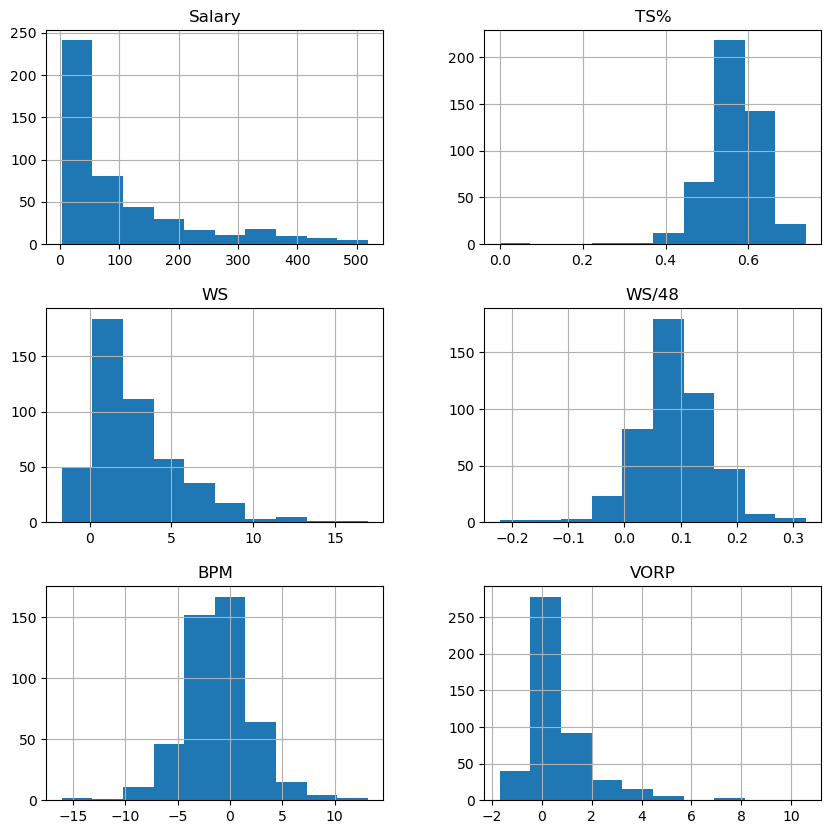

In [4]:
#Histogram of every numerical column
histo_data = nba_data.drop(columns=['Age', 'GP'])
histo = histo_data.hist(bins=10, figsize=(10,10))

#Summary Statistics
histo_data.describe()

#### Salary and TS%

I will be using regression plots that will contain a line of best fit to see if there's still a correlation. For all graphs, I will let the x axis = the amount of salary in hundred thousands and the y axis = the statistic.

I will also call pandas' .corr() fn, which gives a correlation between x and y in the format, x.corr(y). The correlations will be explained in the discussion.

Biggest Outliers: Ryan Arcidiacono, Maxwell Lewis and Jalen Hood-Schifino (for how garbage they are)

Pearson Correlation Coefficient:  0.2246


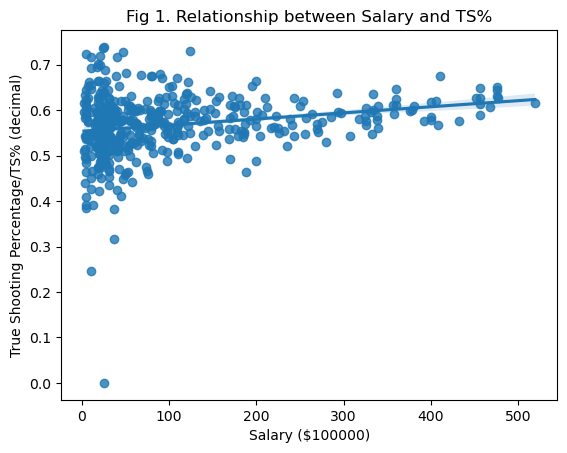

In [5]:
#Plot
ts_plot = sns.regplot(x='Salary', y='TS%', data=nba_data)
ts_plot = ts_plot.set(title='Fig 1. Relationship between Salary and TS%', xlabel='Salary ($100000)', ylabel='True Shooting Percentage/TS% (decimal)')

#Get linear regression coefficient r, round to 4 decimal places, .corr() gives r value, [x].corr([y]), taken from pandas documentation
r = round(nba_data['Salary'].corr(nba_data['TS%']),4)
print('Pearson Correlation Coefficient: ', r)

plt.show(ts_plot)

#### Salary and WS
Leader: Nikola Jokic

Pearson Correlation Coefficient:  0.6561


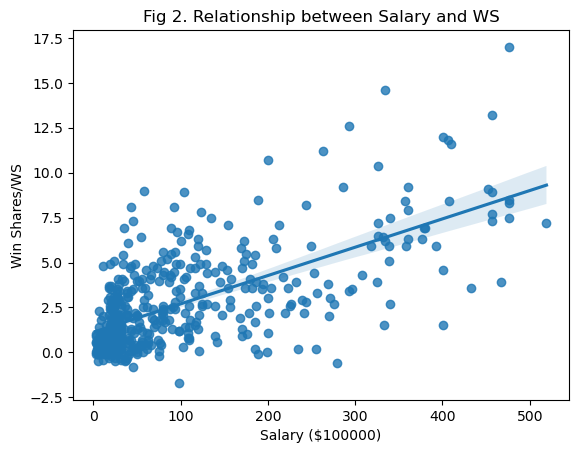

In [6]:
#Plot
ws_plot = sns.regplot(x='Salary', y='WS', data=nba_data)
ws_plot = ws_plot.set(title='Fig 2. Relationship between Salary and WS', xlabel='Salary ($100000)', ylabel='Win Shares/WS')

#Get r, round to 4 decimal places
r = round(nba_data['Salary'].corr(nba_data['WS']),4)
print('Pearson Correlation Coefficient: ', r)

plt.show(ws_plot)

#### Salary and WS/48
Outlier: Leonard Miller

Pearson Correlation Coefficient:  0.3515


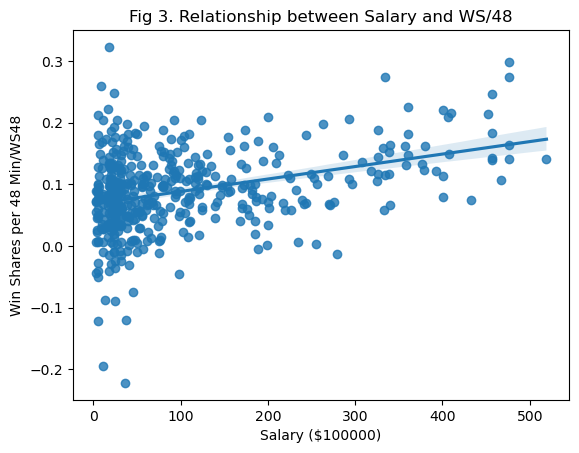

In [7]:
#Plot
ws48_plot = sns.regplot(x='Salary', y='WS/48', data=nba_data)
ws48_plot = ws48_plot.set(title='Fig 3. Relationship between Salary and WS/48', xlabel='Salary ($100000)', ylabel='Win Shares per 48 Min/WS48')

#Get r, round to 4 decimal places
r = round(nba_data['Salary'].corr(nba_data['WS/48']),4)
print('Pearson Correlation Coefficient: ', r)

plt.show(ws48_plot)

#### Salary and BPM
Outlier: Leonard Miller

Leader: Nikola Jokic

Pearson Correlation Coefficient:  0.5187


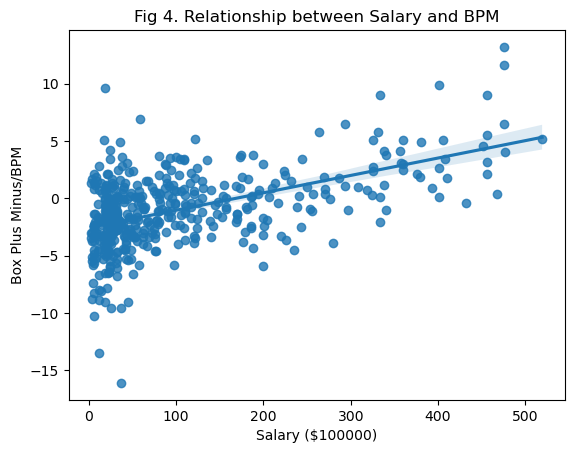

In [8]:
#Plot
bpm_plot = sns.regplot(x='Salary', y='BPM', data=nba_data)
bpm_plot = bpm_plot.set(title='Fig 4. Relationship between Salary and BPM', xlabel='Salary ($100000)', ylabel='Box Plus Minus/BPM')

#Get r, round to 4 decimal places
r = round(nba_data['Salary'].corr(nba_data['BPM']),4)
print('Pearson Correlation Coefficient: ', r)

plt.show(bpm_plot)

#### Salary and VORP
Leader: Nikola Jokic

Pearson Correlation Coefficient:  0.6506


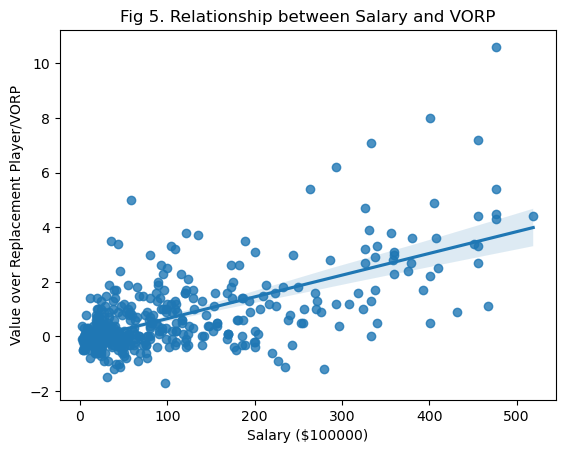

In [9]:
#Plot
vorp_plot = sns.regplot(x='Salary', y='VORP', data=nba_data)
vorp_plot = vorp_plot.set(title='Fig 5. Relationship between Salary and VORP', xlabel='Salary ($100000)', ylabel='Value over Replacement Player/VORP')

#Get r, round to 4 decimal places
r = round(nba_data['Salary'].corr(nba_data['VORP']),4)
print('Pearson Correlation Coefficient: ', r)

plt.show(vorp_plot)

#### Most Efficient Team
Now, I will find the most efficient team by finding the average true shooting percentage of each team. In my opinion, I specifially chose this statistic as the other four focus more on individual performance, while TS% is effective on both team and player performance. To do this, I'll use groupby to group everyone who played only for that team and then call .mean to get the mean. If a player has been on two or more teams, they will not be counted. A tilde(~) has to be used as a false, and not the usual ! for str.contains() to work.

In [10]:
#Use groupby to sort each player by team, get mean true shooting percentage.
grouped_teams = nba_data["TS%"].groupby(nba_data["Team"]).mean()

#Remove all teams with a '/' in their team name by using str.contains
#!x doesn't work here, so we need to use tilde to make it false
grouped_teams = grouped_teams[~grouped_teams.index.str.contains('TOT')]

With grouped_teams having exactly 30 values, it is time to graph Figure 6, which is their teams (x) and average TS% (y). I did a different colour for each team to enhance presentation. I also have to change the range of y so that it starts at 0.5, since every team's TS% is above 50%. Note: this is based on the players who only played for 1 team during this season.

Highest TS% - 0.618
Lowest TS% - 0.519


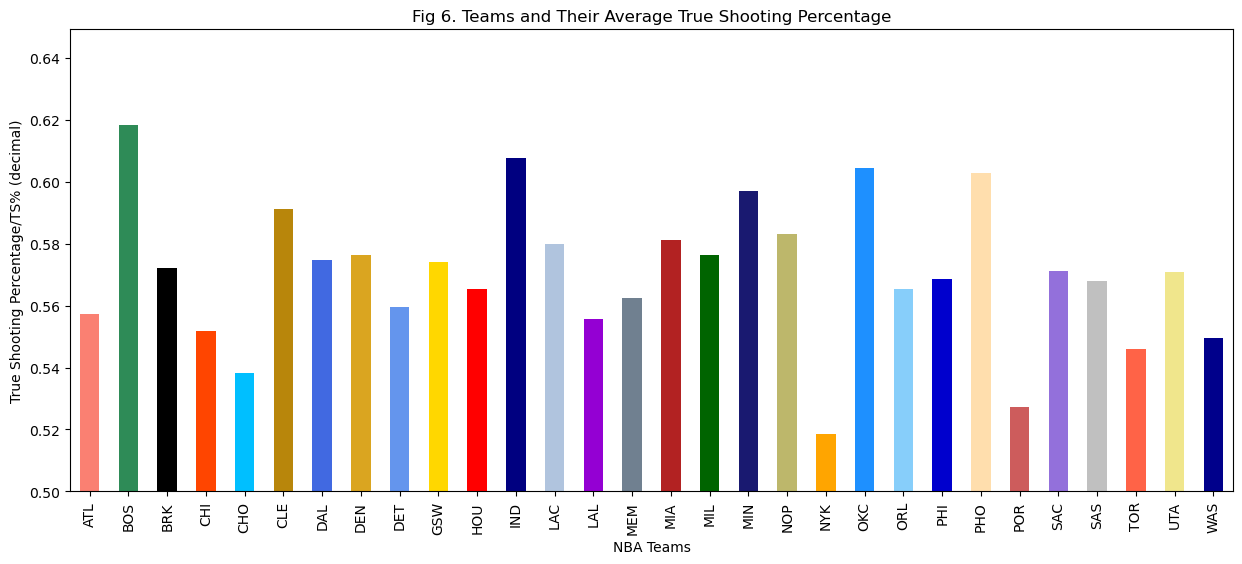

In [11]:
#Create colours list, 1 for every team, inspired by team colours
colours = ['salmon','seagreen','black','orangered','deepskyblue','darkgoldenrod','royalblue','goldenrod','cornflowerblue','gold',
           'red','navy','lightsteelblue','darkviolet','slategray','firebrick','darkgreen','midnightblue','darkkhaki','orange','dodgerblue',
           'lightskyblue','mediumblue','navajowhite','indianred','mediumpurple','silver','tomato','khaki','darkblue']
#Bar Plot
grouped_plot = grouped_teams.plot.bar(color=colours, figsize=(15,6), title='Fig 6. Teams and Their Average True Shooting Percentage')
plt.ylabel("True Shooting Percentage/TS% (decimal)")
plt.xlabel('NBA Teams')

#All teams' average TS% is above .500, need to set range so that y starts at .500
plt.ylim(0.5)

#Print TS%
print(f'Highest TS% - {round(grouped_teams.max(),3)}')
print(f'Lowest TS% - {round(grouped_teams.min(),3)}')

plt.show(grouped_plot)

#### Best Position
Let's check if position still matters when it comes to average performance and salary. I'll start by doing salary first. Like the teams, I'm removing players that have two positions with ~. The reason why is that for those that play two positions, there's only a small sample size, which will heavily skew in favour of them. 

In [12]:
#Use groupby to sort each player by position and get average salary and stats
nba_position = nba_data[['Salary','TS%','WS','WS/48','BPM','VORP']].groupby(nba_data['Position']).mean()

#Remove all players that play 2 positions by using str.contains and tilde
nba_position = nba_position[~nba_position.index.str.contains('-')]

#Summary Table
nba_position.describe()

,Salary,TS%,WS,WS/48,BPM,VORP
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,100.475178,0.567590,2.736353,0.089590,-0.994342,0.677375
std,17.011905,0.028368,0.665917,0.030320,0.876523,0.338160
min,83.278808,0.541617,2.126263,0.065677,-1.984536,0.236082
25%,85.015619,0.555062,2.147423,0.069113,-1.727273,0.453535
50%,99.020321,0.556061,2.734444,0.080099,-0.842222,0.704444
75%,113.113722,0.570211,2.928395,0.092611,-0.595062,0.932099
max,121.947420,0.615000,3.745238,0.140452,0.177381,1.060714


For Figure 7, I decided to use matplotlib's subplots function, so that I don't have to repeat the process of doing a bar graph everytime. This is because with subplots, it creates a matrix of plots. Since I have six statistics that are being used, I can list every statistic plot in the same figure. For the BPM plot, the best position is the one that is closest to 0.

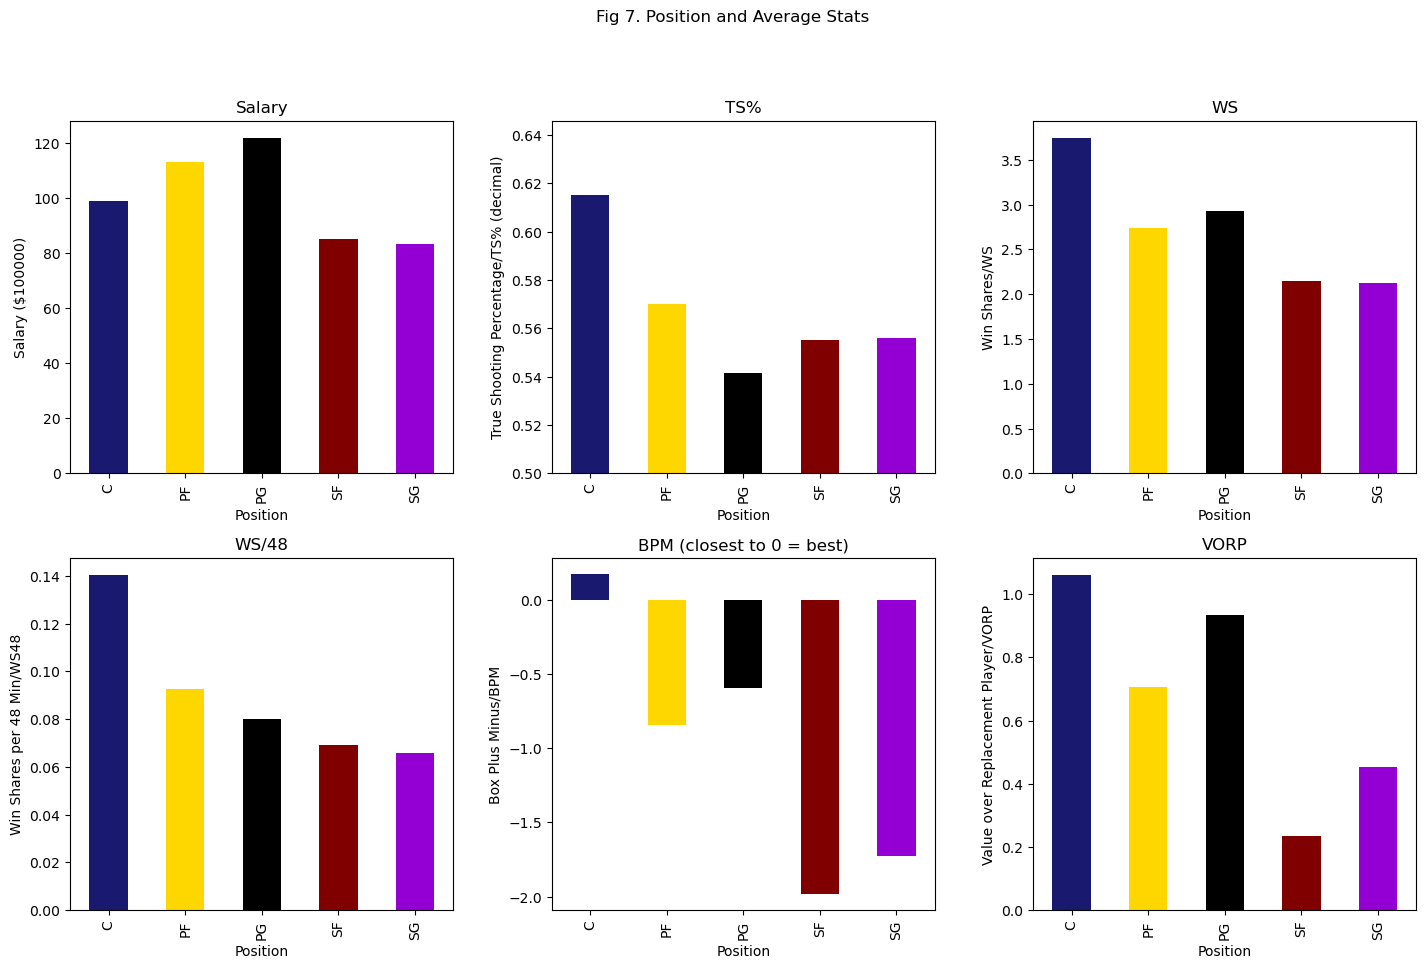

In [13]:
#Create 6 subplots, 1 for each stat
perf_fig, axes = plt.subplots(2,3, figsize=(15,10))
perf_fig.suptitle('Fig 7. Position and Average Stats')
perf_fig.tight_layout(pad=4.0)

#Create another list of colours for position
position_colours = ['midnightblue', 'gold', 'black', 'maroon', 'darkviolet']

#Salary
nba_ts_pos_plot = nba_position['Salary'].plot.bar(ax=axes[0,0], color=position_colours, title='Salary')
nba_ts_pos_plot.set_ylabel('Salary ($100000)')

#True Shooting Percentage
nba_ts_pos_plot = nba_position['TS%'].plot.bar(ax=axes[0,1], color=position_colours, title='TS%')
nba_ts_pos_plot.set_ylabel('True Shooting Percentage/TS% (decimal)')
nba_ts_pos_plot.set_ylim(0.5) #All shoot above 0.500, so set range so that y starts at 0.500

#Win Shares
nba_ws_pos_plot = nba_position['WS'].plot.bar(ax=axes[0,2], color=position_colours, title='WS')
nba_ws_pos_plot.set_ylabel('Win Shares/WS')

# Win Shares per 48 Min
nba_ws48_pos_plot = nba_position['WS/48'].plot.bar(ax=axes[1,0], color=position_colours, title='WS/48')
nba_ws48_pos_plot.set_ylabel('Win Shares per 48 Min/WS48')

#Box Plus Minus
nba_bpm_pos_plot = nba_position['BPM'].plot.bar(ax=axes[1,1], color=position_colours, title='BPM (closest to 0 = best)')
nba_bpm_pos_plot.set_ylabel('Box Plus Minus/BPM')

#Value over Replacement Player
nba_vorp_pos_plot = nba_position['VORP'].plot.bar(ax=axes[1,2], color=position_colours, title='VORP')
nba_vorp_pos_plot.set_ylabel('Value over Replacement Player/VORP')

#Set x axis to position for all subplots
for ax in axes.flat:
    #not having this throws a FixedFormatter warning. Also positions are in alphabetical order
    ax.set_xticks(range(len(['C','PF','PG','SF','SG'])))
    ax.set_xticklabels(['C','PF','PG','SF','SG'])

plt.show(perf_fig)


With Figure 7 being displayed, part 1 is finished.

### Discussion (Part 1)

First, I want to highlight some of the highest paid players that didn't play this season but were still paid. The notable absences were Lonzo Ball, Steven Adams (both due to injuries) and Victor Oladipo (didn't play). As for part 1, I still want to know if the best scenario has changed. Based on figures 1 to 5, there was a positive correlation to salary and performance. In terms of how strong the correlation was based on this website from Boston University [5], Figures 1 and 3 have a weak correlation, Figures 2 and 5 have a strong correlation and Figure 4 had a moderate correlation. This shows that win share and value over a replacement player are both factors that impact the salary, but not efficient shooting. While doing the graphs, there was only 1 big outlier: Leonard Miller, a Small Forward for the Timberwolves. He only played 57 minutes, but based on the stats, he had an effective 57 minutes. I still want to see if the Timberwolves would play him over Jaden McDaniels (doubt), but we have to wait for part 3 to find out. The third highest paid player, Nikola Jokic, was a leader in win shares, BPM and VORP, while the others in the top 5 (Stephen Curry, Kevin Durant, LeBron and Joel Embiid) were all better then average in advanced stats. As for Russell Westbrook and John Wall, 2 of the top 3 highest paid last year, Russ took a huge paycut to around $3.9 million and played ok, but nobody wanted John Wall. 

Based on Figure 6 and the standings [6], many teams that made it to at least the play-in game had the highest true shooting percentage like last year, with the NBA Champion Boston Celtics having the highest this year with 61.8%. The Pacers, Thunder, Suns and Timberwolves also made the playoffs and were in the top 5 in TS%. Portland, Charlotte and Toronto had some of the worst TS% and are bad, but they're not the absolute worst shooters. That goes to the Knicks (huh), a playoff team that was 2nd in the Eastern Conference with a 51.8% TS%, mostly because of Ryan Arcidiacono and their 2 sharpshooters being traded to the Raptors. Yes, unlike last year, there were outliers here. Had RJ Barrett and Immanuel Quickley stay in MSG the entire season, their percentage could've been much higher and potentially might've gotten 1st in the East as well (maybe). There were two other outliers in the Pistons and the Spurs. Both were awful, with the Spurs having the 2nd worst record in the Western Conference, while the Pistons got memed in the first half because of their L streak. However, thanks to people like Cedi Osman on the Spurs and Jalen Duren on the Pistons, they have an average TS%. Therefore, like last year, there is a correlation but it's somewhat weak.

Now, based on Figure 7, Point Guards made the most money, but Centers have the highest advanced stats. Shooting Guards and Small Forwards are still the worst positions, with either of them placing in the bottom two of nearly every graph. The only exception is TS%, where Point Guards are the worst. Again, with players like Joel Embiid, MVP Nikola Jokic, Wemby, Chet Holmgren and Domantas Sabonis, as well as other big men, like Giannis Antetokounmpo, the overall game has shifted in favour of centers and power forwards becoming the best positions. Therefore, the ideal scenario hasn't really changed: become a center and get drafted by a playoff contender.

### Part 2
The battle for Rookie of the Year was very interesting and it revolves around a player from the suburbs of Paris: The San Antonio Spurs player, Victor Wenbanyama. Touted as the next Wilt Chamberlain, with as much hype as LeBron in 2003, Wemby put up a pretty impressive statline, resulting in him unanimously being voted as the Rookie of the Year, as well as being on the All-Defensive first team, the first time a rookie entered the list. While Wemby was expected to win since the start of the season, there were some competition, like OKC's Chet Holmgren: a center who was drafted in 2022, but first played this season and has put up an impressive statline, placing 2nd in overall voting. 


In [32]:
#Create simple Gradient Boost model with Every Rookie of the Year from 2000-2023 (including Wemby)

#Loading Data
roy_data = pd.read_csv('nba_rookies.csv')
roy_data

# Assuming 'WS' (Win Shares) is the target for overall performance
X = roy_data[['TS%', '3PAr', 'FTr', 'ORB%', 'DRB%', 'TRB%', 'AST%', 'STL%', 'BLK%', 'TOV%', 'USG%', 'OWS', 'DWS', 'WS/48', 'OBPM', 'DBPM', 'BPM', 'VORP']]
y = roy_data['WS']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=30)

What I just did is create a training and testing dataset from rookies.csv. The X set has all of the advanced statistics, while the y dataset has win shares, as I think it's a valid indicator of how a player is performing. The average player contributes roughly 2.6 win shares, so it would be very interesting if some young stars will collapse in win shares.

Now, I'll be using XGBoost to create and fine tune the model, which is based on gradient boosted trees. It's important to get a low error here, as the amount of potential win shares a player might have next season should be accurate. 

In [46]:
#Create Regression Matrix
dtrain_reg = xgb.DMatrix(X_train, y_train)
dtest_reg = xgb.DMatrix(X_test, y_test)

params = {"objective": "reg:squarederror", "tree_method": "hist", "device": "cuda"}
evals = [(dtest_reg, "validation"), (dtrain_reg, "train")]
n = 200


model = xgb.train(
   params=params,
   dtrain=dtrain_reg,
   num_boost_round=n,
   evals=evals,
   verbose_eval=100,
   # Activate early stopping
   early_stopping_rounds=50
)

#Cross Validation
results = xgb.cv(
   params, dtrain_reg,
   num_boost_round=n,
   nfold=5,
   early_stopping_rounds=20
)

#Check Error
preds = model.predict(dtest_reg)
rmse = root_mean_squared_error(y_test, preds)
print(f"RMSE of the base model: {rmse:.3f}")
print(f"R^2 of the base model: {r2_score(y_test, preds):.3f}")

results.head()

[0]	validation-rmse:3.74212	train-rmse:3.11819


[100]	validation-rmse:0.47807	train-rmse:0.00077
[154]	validation-rmse:0.47807	train-rmse:0.00077
RMSE of the base model: 0.478
R^2 of the base model: 0.991


,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,3.125270,0.071294,3.171964,0.352593
1,2.287638,0.049317,2.380195,0.304623
2,1.684241,0.033971,1.822759,0.266939
3,1.246906,0.023514,1.447821,0.216526
4,0.928409,0.016144,1.166339,0.166887


Now that we've got our model, I'll finally apply it to the data. The dataset will only include people who are under 25 as of the 2024-2025 season (i.e. people who are born in 2000-2004).

In [48]:
young_players = nba_data[nba_data['Age'] < 24]
young_players

,Player,Salary,Position,Age,Team,GP,TS%,WS,WS/48,BPM,VORP
30,Zion Williamson,340.052,PF,23,NOP,70,0.610,7.5,0.164,3.8,3.3
60,RJ Barrett,238.839,SG,23,TOT,58,0.580,2.9,0.075,-0.8,0.6
113,Anthony Edwards,135.348,SG,22,MIN,79,0.575,7.5,0.130,3.3,3.7
124,Victor Wembanyama,121.606,C,20,SAS,71,0.565,3.7,0.085,5.2,3.8
125,James Wiseman,121.194,C,22,DET,63,0.637,2.1,0.094,-3.5,-0.4
...,...,...,...,...,...,...,...,...,...,...,...
507,Johnny Juzang,5.598,SG,22,UTA,20,0.620,0.4,0.047,-3.7,-0.2
513,Ibou Badji,4.665,C,21,POR,22,0.623,0.2,0.046,-5.8,-0.2
523,Vit Krejci,3.700,PG,23,ATL,22,0.633,0.6,0.056,-3.7,-0.2
527,Tosan Evbuomwan,2.960,SF,22,TOT,17,0.616,0.5,0.071,-3.0,-0.1


The only two people here that got really high salaries are Zion Williamson and RJ Barrett, as they got new contract before the start of that season. If we were doing this based on this upcoming season, Ant would be the one with the highest salary as he got a 6 year contract extension worth $260 million. 

### References
#### Website References (IEEE)
[1] J. Welsh, “NBA player salaries (2022-23 season),” Kaggle, https://www.kaggle.com/datasets/jamiewelsh2/nba-player-salaries-2022-23-season (accessed Nov. 25, 2023).

[2] “Basketball true shooting percentage: Wolfram Formula Repository,” Basketball True Shooting Percentage | Wolfram Formula Repository, https://resources.wolframcloud.com/FormulaRepository/resources/Basketball-True-Shooting-Percentage (accessed Nov. 25, 2023). 

[3] “NBA Win Shares,” Basketball Reference, https://www.basketball-reference.com/about/ws.html (accessed Nov. 25, 2023). 

[4] “About box plus/minus (BPM),” Basketball, https://www.basketball-reference.com/about/bpm2.html (accessed Nov. 25, 2023). 

[5] “PH717 module 9 - correlation and regression: The correlation coefficient (r),” Boston University, https://sphweb.bumc.bu.edu/otlt/MPH-Modules/PH717-QuantCore/PH717-Module9-Correlation-Regression/PH717-Module9-Correlation-Regression4.html (accessed Nov. 25, 2023).

[6] “NBA standings - 2023-24 regular season conference standings,” ESPN, https://www.espn.com/nba/standings/_/season/2024 (accessed Aug. 16, 2024).

[7] “NBA & ABA Rookie of the Year (Wilt Chamberlain Trophy) Award Winners” Basketball Reference, https://www.basketball-reference.com/awards/roy.html (accessed Aug. 23, 2024).

[8] “Basketball Reference Rookie Player MegaDoc” Basketball Reference and Koops_0, https://docs.google.com/document/d/1bRabM7dfNtfQNb-Mr2e4oZCke1eZkexiGBzRBe9Akrg/edit?usp=sharing (created and accessed Aug. 23, 2024).

#### Python Library References and Documentation Websites
* pandas for reading the csv, as well as cleaning, manipulating and grouping the data, https://pandas.pydata.org/docs/reference/ 
* seaborn for data visualization, https://seaborn.pydata.org/api.html
* matplotlib for data visualization, https://matplotlib.org/stable/api/index.html
* BeautifulSoup for data scraping, https://www.crummy.com/software/BeautifulSoup/bs4/doc/
* Scikit-Learn for Machine Learning, https://scikit-learn.org/stable/
* XGBoost for Machine Learning, https://xgboost.readthedocs.io/en/stable/